In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
data = 'https://raw.githubusercontent.com/Dimassaputra5/DataQuest/refs/heads/main/training_dataset.csv'
data_validation = 'https://raw.githubusercontent.com/Dimassaputra5/DataQuest/refs/heads/main/validation_set.csv'
cc = pd.read_csv(data, 
                 encoding='utf-8',  # atau 'latin1', 'iso-8859-1', dll
                 sep=',')
cc_validation = pd.read_csv(data_validation, 
                 encoding='utf-8',  # atau 'latin1', 'iso-8859-1', dll
                 sep=',')
cc

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22911,680377,32,teknisi,menikah,Diploma,no,yes,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,Kalimantan,0
22912,505429,30,mahasiswa,lajang,Diploma,no,no,no,telephone,sep,...,999,0,nonexistent,-1.1,94.199,-37.5,0.880,4963.6,Bali,0
22913,308952,29,manajer,lajang,SMA,no,yes,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,NTT,0
22914,865813,52,entrepreneur,menikah,Tidak Tamat SD,unknown,yes,no,telephone,jun,...,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,NTB,0


In [32]:
cc_validation

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,445420,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,585604,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,888824,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,816820,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,542716,45,teknisi,cerai,SMA,no,yes,no,cellular,may,...,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,782072,51,pekerja kasar,menikah,Tidak Tamat SD,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,Kalimantan
5725,116371,30,pekerja kasar,menikah,SMP,no,yes,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,Sulawesi
5726,773759,45,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NTB
5727,612330,60,teknisi,menikah,Diploma,unknown,no,no,telephone,jul,...,15,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,Papua


In [33]:
cc.info()
cc_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [34]:
cc['status_perkawinan'].unique()
cc['status_perkawinan'] = cc['status_perkawinan'].map({'menikah': 1, 'lajang':2, 'cerai': 3, 'unknown': 4})
cc['status_perkawinan'].unique()
##########################################################
cc_validation['status_perkawinan'] = cc_validation['status_perkawinan'].map({'menikah': 1, 'lajang':2, 'cerai': 3, 'unknown': 4})


In [35]:
cc['RasioPekerjaSukuBunga'] = cc['jumlah_pekerja']/cc['suku_bunga_euribor_3bln']
###################################################
cc_validation['RasioPekerjaSukuBunga'] = cc_validation['jumlah_pekerja']/cc_validation['suku_bunga_euribor_3bln']

In [36]:
cc['gagal_bayar_sebelumnya'].unique()
cc['gagal_bayar_sebelumnya'] = cc['gagal_bayar_sebelumnya'].map({'no': 0, 'yes': 1, 'unknown': 2})
cc['gagal_bayar_sebelumnya'].unique()
###############################################
cc_validation['gagal_bayar_sebelumnya'] = cc_validation['gagal_bayar_sebelumnya'].map({'no': 0, 'yes': 1, 'unknown': 2})


In [37]:
cc['pinjaman_rumah'].unique()
cc['pinjaman_rumah'] = cc['pinjaman_rumah'].map({'no': 0, 'yes': 1, 'unknown': 2})
cc['pinjaman_rumah'].unique()
##############################################
cc_validation['pinjaman_rumah'] = cc_validation['pinjaman_rumah'].map({'no': 0, 'yes': 1, 'unknown': 2})


In [38]:
cc['pinjaman_pribadi'].unique()
cc['pinjaman_pribadi'] = cc['pinjaman_pribadi'].map({'no': 0, 'yes': 1, 'unknown': 2})
cc['pinjaman_pribadi'].unique()
################################################
cc_validation['pinjaman_pribadi'] = cc_validation['pinjaman_pribadi'].map({'no': 0, 'yes': 1, 'unknown': 2})


In [39]:
cc['jenis_kontak'].unique()
cc['jenis_kontak'] = cc['jenis_kontak'].map({'cellular': 1, 'telephone': 2})
cc['jenis_kontak'].unique()
##########################################################
cc_validation['jenis_kontak'] = cc_validation['jenis_kontak'].map({'cellular': 1, 'telephone': 2})


In [40]:
cc['bulan_kontak_terakhir'].unique()
cc['bulan_kontak_terakhir'] = cc['bulan_kontak_terakhir'].map({
    'jul': 7, 'nov': 11, 'may': 5, 'aug': 8, 'oct': 10, 'apr': 4, 'jun': 6, 'sep': 9, 'mar': 3, 'dec':12
}).astype(int)
cc['bulan_kontak_terakhir'].unique()
#####################################################################
cc_validation['bulan_kontak_terakhir'] = cc_validation['bulan_kontak_terakhir'].map({
    'jul': 7, 'nov': 11, 'may': 5, 'aug': 8, 'oct': 10, 'apr': 4, 'jun': 6, 'sep': 9, 'mar': 3, 'dec':12
}).astype(int)

In [41]:
cc['hari_kontak_terakhir'].unique()
cc['hari_kontak_terakhir'] = cc['hari_kontak_terakhir'].map({
    'fri': 5, 'thu': 4, 'wed': 3, 'tue': 2, 'mon': 7})
cc['hari_kontak_terakhir'].unique()
##############################################################
cc_validation['hari_kontak_terakhir'] = cc_validation['hari_kontak_terakhir'].map({
    'fri': 5, 'thu': 4, 'wed': 3, 'tue': 2, 'mon': 7})

In [42]:
cc['hasil_kampanye_sebelumnya'].unique()
cc['hasil_kampanye_sebelumnya'] = cc['hasil_kampanye_sebelumnya'].map({
    'nonexistent': 0, 'failure': 1, 'success': 2
})
###################################################################
cc_validation['hasil_kampanye_sebelumnya'] = cc_validation['hasil_kampanye_sebelumnya'].map({
    'nonexistent': 0, 'failure': 1, 'success': 2
})

In [43]:
cc['berlangganan_deposito'] = cc['berlangganan_deposito'].astype(float)
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  int64  
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  int64  
 6   pinjaman_rumah                22916 non-null  int64  
 7   pinjaman_pribadi              22916 non-null  int64  
 8   jenis_kontak                  22916 non-null  int64  
 9   bulan_kontak_terakhir         22916 non-null  int64  
 10  hari_kontak_terakhir          22916 non-null  int64  
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [44]:
cc['total_kontak'] = cc['jumlah_kontak_kampanye_ini'] + cc['jumlah_kontak_sebelumnya']
###################################
cc_validation['total_kontak'] = cc_validation['jumlah_kontak_kampanye_ini'] + cc_validation['jumlah_kontak_sebelumnya']

In [45]:
cc['memiliki_pinjaman'] = cc['pinjaman_pribadi'] | cc['pinjaman_rumah']
###################################
cc_validation['memiliki_pinjaman'] = cc_validation['pinjaman_pribadi'] | cc_validation['pinjaman_rumah']

In [46]:
cc['rasio_ekonomi'] = cc['suku_bunga_euribor_3bln']/cc['indeks_harga_konsumen']
####################################
cc_validation['rasio_ekonomi'] = cc_validation['suku_bunga_euribor_3bln']/cc_validation['indeks_harga_konsumen']

In [47]:
cc['variasipekerjaanterhadapsukubunga'] = cc['tingkat_variasi_pekerjaan']/cc['suku_bunga_euribor_3bln']
#########################################################
cc_validation['variasipekerjaanterhadapsukubunga'] = cc_validation['tingkat_variasi_pekerjaan']/cc_validation['suku_bunga_euribor_3bln']


<Axes: >

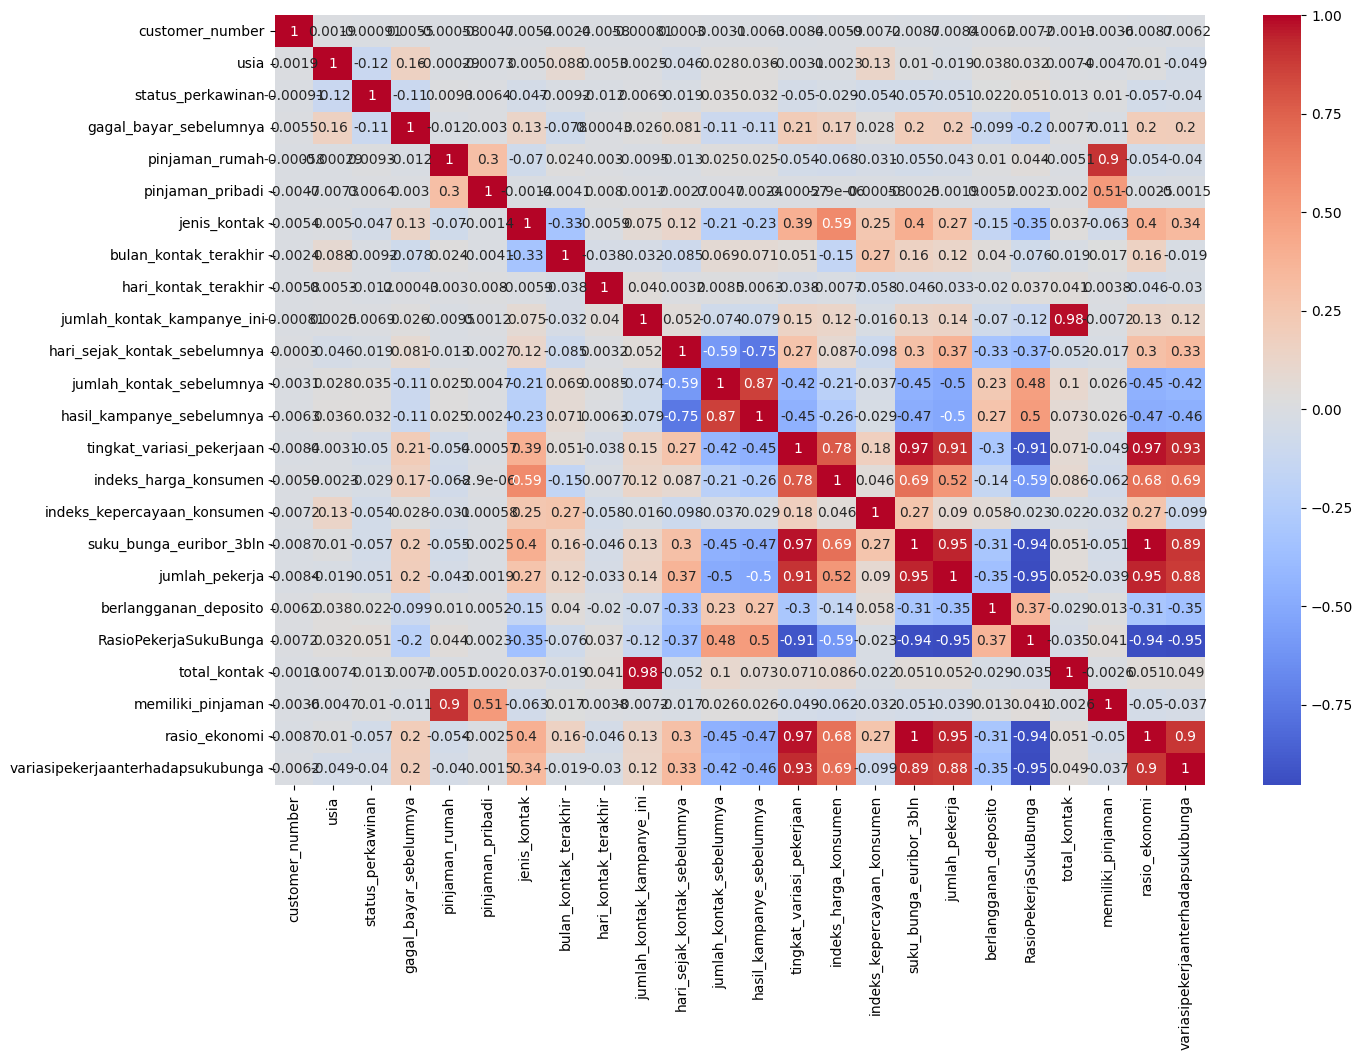

In [48]:
cc_num = cc.select_dtypes(include=np.number)
corelation_matrix = cc_num.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corelation_matrix, annot=True ,cmap='coolwarm')

    

In [49]:
# First create the correlation matrix
correlation_matrix = cc_num.corr()

# Convert the correlation matrix to a more manageable format
# This will give us pairs of features and their correlation values
correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):  # Start from i+1 to avoid duplicates
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.4:  # Check for absolute correlation > 0.4
            correlations.append({
                'feature1': col1,
                'feature2': col2,
                'correlation': corr_value
            })

# Sort by absolute correlation value and print
correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)

print("Strong correlations (|correlation| > 0.4):")
print("-" * 50)
for corr in correlations:
    print(f"{corr['feature1']} vs {corr['feature2']}: {corr['correlation']:.3f}")

# Alternatively, if you just want the values:
print("\nJust correlation values > 0.4:")
print("-" * 50)
for corr in correlations:
    print(f"{corr['correlation']:.3f}")

Strong correlations (|correlation| > 0.4):
--------------------------------------------------
suku_bunga_euribor_3bln vs rasio_ekonomi: 1.000
jumlah_kontak_kampanye_ini vs total_kontak: 0.985
tingkat_variasi_pekerjaan vs suku_bunga_euribor_3bln: 0.972
tingkat_variasi_pekerjaan vs rasio_ekonomi: 0.971
RasioPekerjaSukuBunga vs variasipekerjaanterhadapsukubunga: -0.954
jumlah_pekerja vs RasioPekerjaSukuBunga: -0.954
jumlah_pekerja vs rasio_ekonomi: 0.946
suku_bunga_euribor_3bln vs jumlah_pekerja: 0.945
RasioPekerjaSukuBunga vs rasio_ekonomi: -0.944
suku_bunga_euribor_3bln vs RasioPekerjaSukuBunga: -0.943
tingkat_variasi_pekerjaan vs variasipekerjaanterhadapsukubunga: 0.925
tingkat_variasi_pekerjaan vs RasioPekerjaSukuBunga: -0.911
tingkat_variasi_pekerjaan vs jumlah_pekerja: 0.907
pinjaman_rumah vs memiliki_pinjaman: 0.901
rasio_ekonomi vs variasipekerjaanterhadapsukubunga: 0.895
suku_bunga_euribor_3bln vs variasipekerjaanterhadapsukubunga: 0.895
jumlah_pekerja vs variasipekerjaanterhadap

In [50]:
cc_validation.info()
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_number                    5729 non-null   int64  
 1   usia                               5729 non-null   int64  
 2   pekerjaan                          5729 non-null   object 
 3   status_perkawinan                  5729 non-null   int64  
 4   pendidikan                         5729 non-null   object 
 5   gagal_bayar_sebelumnya             5729 non-null   int64  
 6   pinjaman_rumah                     5729 non-null   int64  
 7   pinjaman_pribadi                   5729 non-null   int64  
 8   jenis_kontak                       5729 non-null   int64  
 9   bulan_kontak_terakhir              5729 non-null   int64  
 10  hari_kontak_terakhir               5729 non-null   int64  
 11  jumlah_kontak_kampanye_ini         5729 non-null   int64

In [51]:
cc.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pekerjaan   22916 non-null  object
 1   pendidikan  22916 non-null  object
 2   pulau       22916 non-null  object
dtypes: object(3)
memory usage: 537.2+ KB


In [52]:
cc = pd.get_dummies(cc, columns=['pekerjaan', 'pendidikan', 'pulau'], drop_first=True)
cc.info()
cc.head()
################################################
cc_validation = pd.get_dummies(cc_validation, columns=['pekerjaan', 'pendidikan', 'pulau'], drop_first=True)
cc_validation.info()
cc_validation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_number                    22916 non-null  int64  
 1   usia                               22916 non-null  int64  
 2   status_perkawinan                  22916 non-null  int64  
 3   gagal_bayar_sebelumnya             22916 non-null  int64  
 4   pinjaman_rumah                     22916 non-null  int64  
 5   pinjaman_pribadi                   22916 non-null  int64  
 6   jenis_kontak                       22916 non-null  int64  
 7   bulan_kontak_terakhir              22916 non-null  int64  
 8   hari_kontak_terakhir               22916 non-null  int64  
 9   jumlah_kontak_kampanye_ini         22916 non-null  int64  
 10  hari_sejak_kontak_sebelumnya       22916 non-null  int64  
 11  jumlah_kontak_sebelumnya           22916 non-null  int

,customer_number,usia,status_perkawinan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,...,pendidikan_TIDAK SEKOLAH,pendidikan_Tidak Tamat SD,pendidikan_unknown,pulau_Jawa,pulau_Kalimantan,pulau_NTB,pulau_NTT,pulau_Papua,pulau_Sulawesi,pulau_Sumatera
0,445420,35,1,0,1,1,1,7,7,1,...,False,False,False,True,False,False,False,False,False,False
1,585604,52,2,2,0,0,2,5,4,4,...,False,False,False,False,False,False,False,True,False,False
2,888824,37,1,2,1,0,2,5,3,3,...,False,False,False,False,False,False,False,False,False,False
3,816820,51,1,0,0,0,2,5,2,3,...,False,False,False,False,False,False,False,False,False,True
4,542716,45,3,0,1,0,1,5,4,1,...,False,False,False,False,False,False,False,False,False,True


# Modeling

In [53]:
from cuml.ensemble import RandomForestRegressor
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error, r2_score
import optuna
import cudf
import cupy

In [54]:
cc = cudf.DataFrame(cc)

Calculated AUC score: 0.333


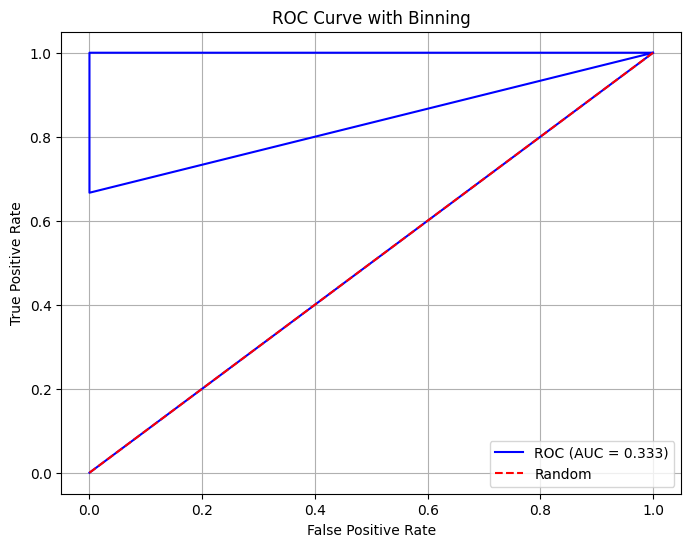

In [55]:
import numpy as np
from typing import List, Union, Tuple
import cudf
import cupy as cp

def calculate_auc_binning(y_true: Union[List, np.ndarray, cudf.Series], 
                         y_pred: Union[List, np.ndarray, cudf.Series], 
                         n_bins: int = 10) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Calculate AUC (Area Under Curve) using binning method.
    Supports both CPU (numpy) and GPU (cudf/cupy) data.
    
    Args:
        y_true: List, array, or cudf.Series of true labels (0 or 1)
        y_pred: List, array, or cudf.Series of prediction probabilities (between 0 and 1)
        n_bins: Number of bins to use for calculation (default: 10)
    
    Returns:
        tuple: (auc_score, fpr_array, tpr_array)
            - auc_score: The calculated AUC score
            - fpr_array: Array of False Positive Rates
            - tpr_array: Array of True Positive Rates
    """
    # Check if input is cudf Series and convert to numpy
    if isinstance(y_true, cudf.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, cudf.Series):
        y_pred = y_pred.to_numpy()
    
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Input validation
    if len(y_true) != len(y_pred):
        raise ValueError("Length of y_true and y_pred must be equal")
    if not np.all(np.isin(y_true, [0, 1])):
        raise ValueError("y_true must contain only binary values (0 or 1)")
    if np.any(y_pred < 0) or np.any(y_pred > 1):
        raise ValueError("y_pred must contain values between 0 and 1")
    if n_bins < 2:
        raise ValueError("n_bins must be at least 2")

    # Create bins
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred, bins) - 1
    
    # Initialize arrays for TPR and FPR
    tpr_array = np.zeros(n_bins)
    fpr_array = np.zeros(n_bins)
    
    # Calculate TPR and FPR for each bin
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            # True Positives and False Positives for current bin and above
            current_and_above = bin_indices >= i
            tp = np.sum((y_true == 1) & current_and_above)
            fp = np.sum((y_true == 0) & current_and_above)
            
            # All Positives and All Negatives
            all_positives = np.sum(y_true == 1)
            all_negatives = np.sum(y_true == 0)
            
            # Calculate rates (handle division by zero)
            tpr_array[i] = tp / all_positives if all_positives > 0 else 0
            fpr_array[i] = fp / all_negatives if all_negatives > 0 else 0
    
    # Add points (0,0) and (1,1) for complete curve
    tpr_array = np.concatenate(([0], tpr_array, [1]))
    fpr_array = np.concatenate(([0], fpr_array, [1]))
    
    # Calculate AUC using trapezoidal rule
    auc_score = np.trapz(tpr_array, fpr_array)
    
    return auc_score, fpr_array, tpr_array

# Example usage and visualization
def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray, auc_score: float) -> None:
    """
    Plot the ROC curve with the calculated AUC score.
    
    Args:
        fpr: Array of False Positive Rates
        tpr: Array of True Positive Rates
        auc_score: The calculated AUC score
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Binning')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example with cuDF data
    import cudf
    
    # Create sample data using cuDF
    df = cudf.DataFrame({
        'true_labels': [0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        'pred_probs': [0.1, 0.7, 0.8, 0.3, 0.9, 0.2, 0.8, 0.7, 0.4, 0.9]
    })
    
    # Calculate AUC using binning
    auc_score, fpr, tpr = calculate_auc_binning(
        df['true_labels'], 
        df['pred_probs'], 
        n_bins=5
    )
    print(f"Calculated AUC score: {auc_score:.3f}")
    
    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, auc_score)

[I 2025-05-21 13:55:22,828] A new study created in memory with name: no-name-8702a3de-b4aa-4a36-9014-0ca96cfdfa1f
[I 2025-05-21 13:55:23,760] Trial 0 finished with value: 0.1373750606902198 and parameters: {'n_estimators': 186, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.1373750606902198.
[I 2025-05-21 13:55:24,346] Trial 1 finished with value: 0.1369967112781675 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.1369967112781675.
[I 2025-05-21 13:55:24,881] Trial 2 finished with value: 0.13039036069661974 and parameters: {'n_estimators': 183, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.13039036069661974.
[I 2025-05-21 13:55:25,902] Trial 3 finished with value: 0.13914198458570018 and parameters: {'n_estimators': 103, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 2 wi

best parameter {'n_estimators': 43, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 12}
Final MSE: 0.12982611679421546
AUC Score: 0.282


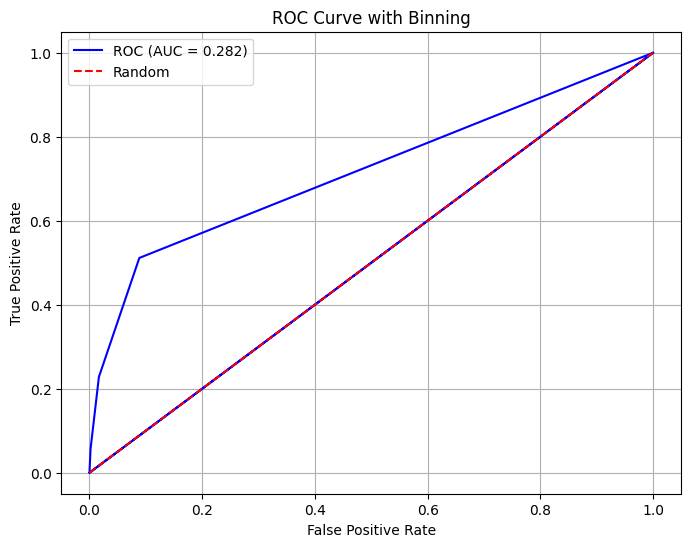

0.0824530924791244 0.18844882377720906 0.28248012401229255
0    0.116101
1    0.061677
2    0.134476
3    0.060625
4    0.062385
5    0.061143
6    0.136247
7    0.053581
8    0.134652
9    0.070915
dtype: float64


In [56]:
X = cc.drop(columns=['berlangganan_deposito'], axis=1)
y = cc['berlangganan_deposito']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            bootstrap=True,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features='sqrt',
            n_streams=1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mse = ((y_val - y_pred)**2).mean()

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 100)

best_params = study.best_params
print("best parameter", best_params)

best_model = RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            random_state=42,
            bootstrap=True,
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features='sqrt',
            n_streams=1)


best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)

mse = ((y_val - y_pred) ** 2).mean()
print("Final MSE:", mse)

auc_score, fpr, tpr = calculate_auc_binning(y_val, y_pred, n_bins=5)
print(f"AUC Score: {auc_score:.3f}")
plot_roc_curve(fpr, tpr, auc_score)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(mse, r2,auc_score)
print(y_pred[:10]) 

In [57]:
# X_train = cc.drop(columns=['berlangganan_deposito'], axis=1)
# y_train = cc['berlangganan_deposito']
# X_validation = cc_validation

# X_train = cudf.DataFrame(X_train)
# y_train = cudf.Series(y_train)
# X_validation = cudf.DataFrame(X_validation)

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_validation = scaler.transform(X_validation)

# model = RandomForestRegressor(
#         n_estimators=100,
#         max_depth=6,
#         random_state=42,
#         bootstrap=True,
#         min_samples_split=3,
#         max_features='sqrt',
#         n_streams=1)

# model.fit(X_train, y_train)

# y_val_pred = model.predict(X_validation)

# print(y_val_pred[:10]) 

# submission = cudf.DataFrame({'customer_number': cc_validation['customer_number'] ,'berlangganan_deposito': y_val_pred})
# submission.to_csv("Validation Result Submission.csv", index=False)